In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import os

## Load Noise Measurements

Load all CSV files from the noise_testing directory. Add your measurement files here.

In [31]:
# Load all noise measurement files
noise_files = glob.glob("static_noise_*.csv")
noise_files.sort()

print(f"Found {len(noise_files)} noise measurement files:")
for f in noise_files:
    print(f"  - {f}")

# Load data into dictionary
noise_data = {}
for file in noise_files:
    label = file.replace('static_noise_', '').replace('.csv', '')
    noise_data[label] = pd.read_csv(file)
    print(f"Loaded {label}: {len(noise_data[label])} samples")

Found 2 noise measurement files:
  - static_noise_20251202_093837_sin_motor_belt.csv
  - static_noise_20251202_093944.csv
Loaded 20251202_093837_sin_motor_belt: 2498953 samples
Loaded 20251202_093944: 1399711 samples
Loaded 20251202_093837_sin_motor_belt: 2498953 samples
Loaded 20251202_093944: 1399711 samples


## Statistical Analysis

Calculate key noise statistics for each measurement.

In [32]:
# Calculate statistics for each measurement
stats_list = []

for label, df in noise_data.items():
    voltage = df['Voltage_V']
    
    stats = {
        'Measurement': label,
        'Mean (V)': voltage.mean(),
        'Std Dev (V)': voltage.std(),
        'RMS (V)': np.sqrt(np.mean(voltage**2)),
        'Peak-to-Peak (V)': voltage.max() - voltage.min(),
        'Max (V)': voltage.max(),
        'Min (V)': voltage.min(),
        'Samples': len(voltage)
    }
    stats_list.append(stats)

stats_df = pd.DataFrame(stats_list)
stats_df

,Measurement,Mean (V),Std Dev (V),RMS (V),Peak-to-Peak (V),Max (V),Min (V),Samples
0,20251202_093837_sin_motor_belt,0.002723,0.197993,0.198012,0.643083,0.321416,-0.321667,2498953
1,20251202_093944,0.004124,0.223385,0.223423,0.739871,0.372602,-0.367270,1399711


## Time Domain Plots

Visualize the noise in the time domain.

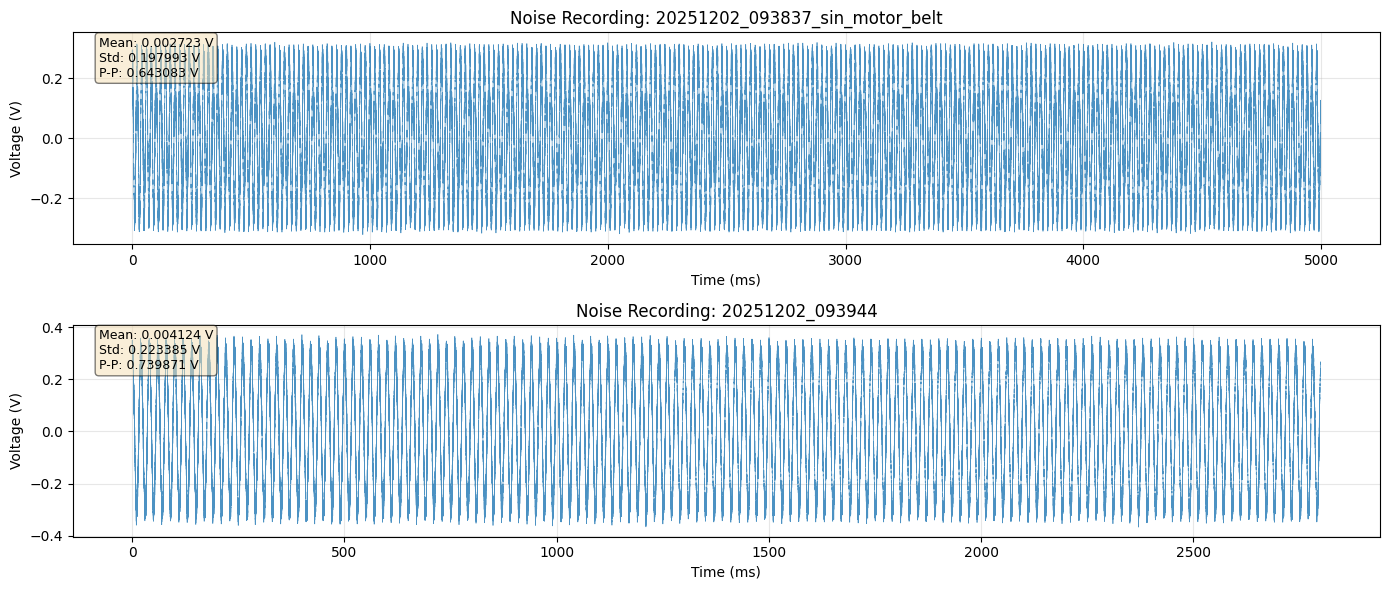

In [33]:
# Plot all measurements (full duration)
fig, axes = plt.subplots(len(noise_data), 1, figsize=(14, 3*len(noise_data)))

if len(noise_data) == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, noise_data.items()):
    ax.plot(df['Timestamp_ms'], df['Voltage_V'], linewidth=0.5, alpha=0.8)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (V)')
    ax.set_title(f'Noise Recording: {label}')
    ax.grid(alpha=0.3)
    
    # Add statistics text
    stats = stats_df[stats_df['Measurement'] == label].iloc[0]
    text = f"Mean: {stats['Mean (V)']:.6f} V\nStd: {stats['Std Dev (V)']:.6f} V\nP-P: {stats['Peak-to-Peak (V)']:.6f} V"
    ax.text(0.02, 0.98, text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

## Zoomed View (First 100ms)

Closer look at the noise characteristics.

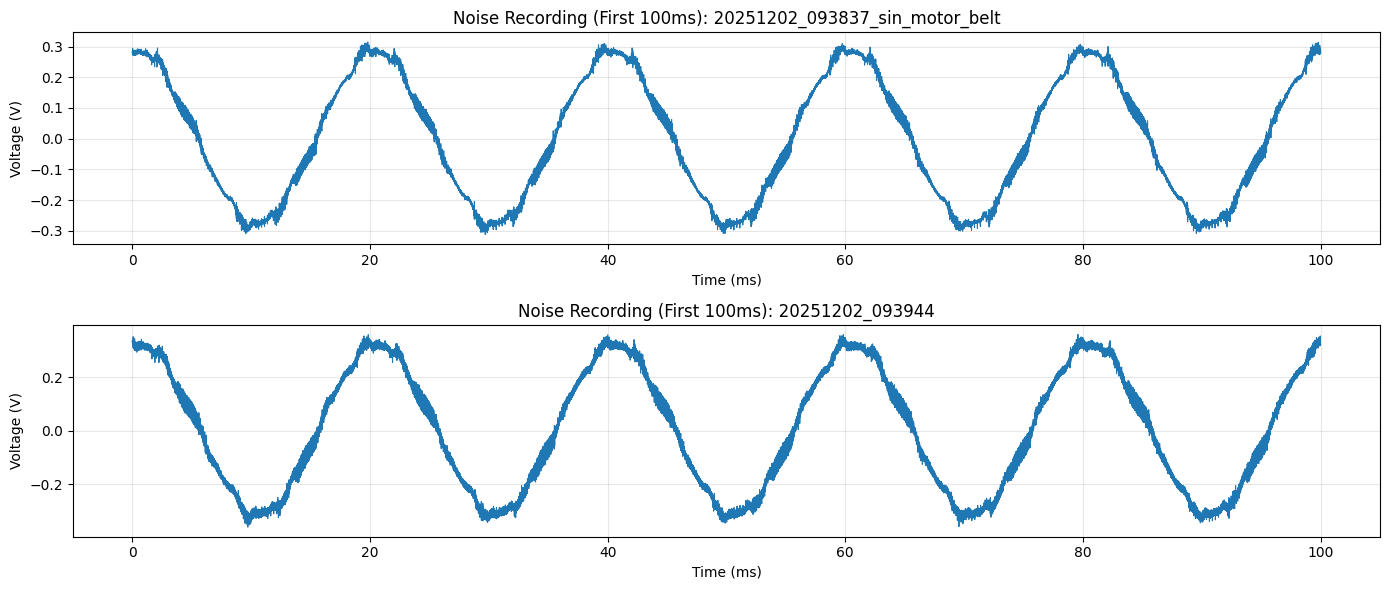

In [34]:
# Plot first 100ms for detailed view
fig, axes = plt.subplots(len(noise_data), 1, figsize=(14, 3*len(noise_data)))

if len(noise_data) == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, noise_data.items()):
    # Plot only first 100ms
    mask = df['Timestamp_ms'] <= 100
    ax.plot(df[mask]['Timestamp_ms'], df[mask]['Voltage_V'], linewidth=0.8)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (V)')
    ax.set_title(f'Noise Recording (First 100ms): {label}')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Histogram of Voltage Distribution

Show the distribution of voltage values to assess noise characteristics.

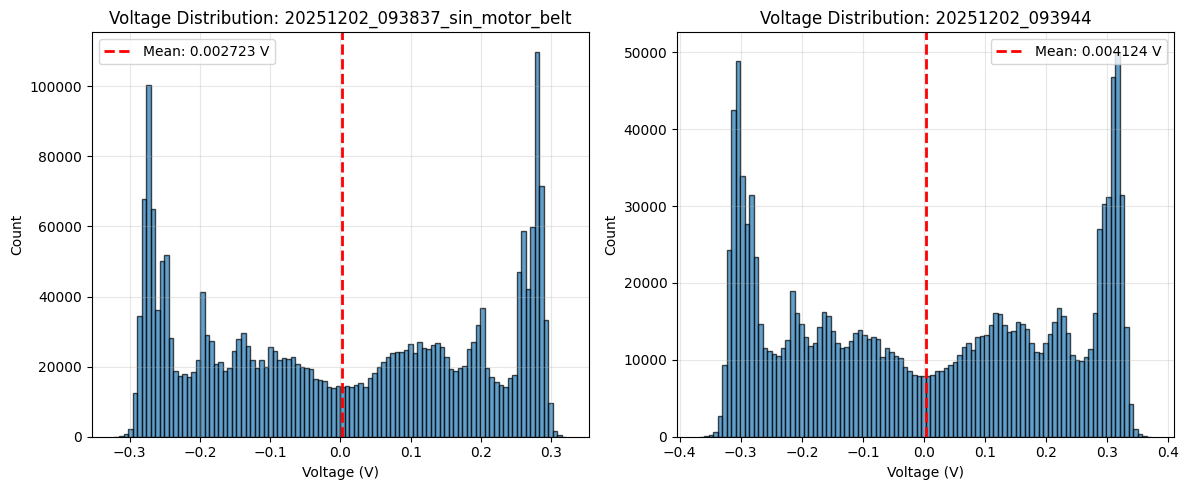

In [35]:
# Histogram for each measurement
fig, axes = plt.subplots(1, len(noise_data), figsize=(6*len(noise_data), 5))

if len(noise_data) == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, noise_data.items()):
    voltage = df['Voltage_V']
    ax.hist(voltage, bins=100, alpha=0.7, edgecolor='black')
    ax.axvline(voltage.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {voltage.mean():.6f} V')
    ax.set_xlabel('Voltage (V)')
    ax.set_ylabel('Count')
    ax.set_title(f'Voltage Distribution: {label}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Frequency Domain Analysis (FFT)

Analyze the frequency content of the noise to identify any periodic interference.

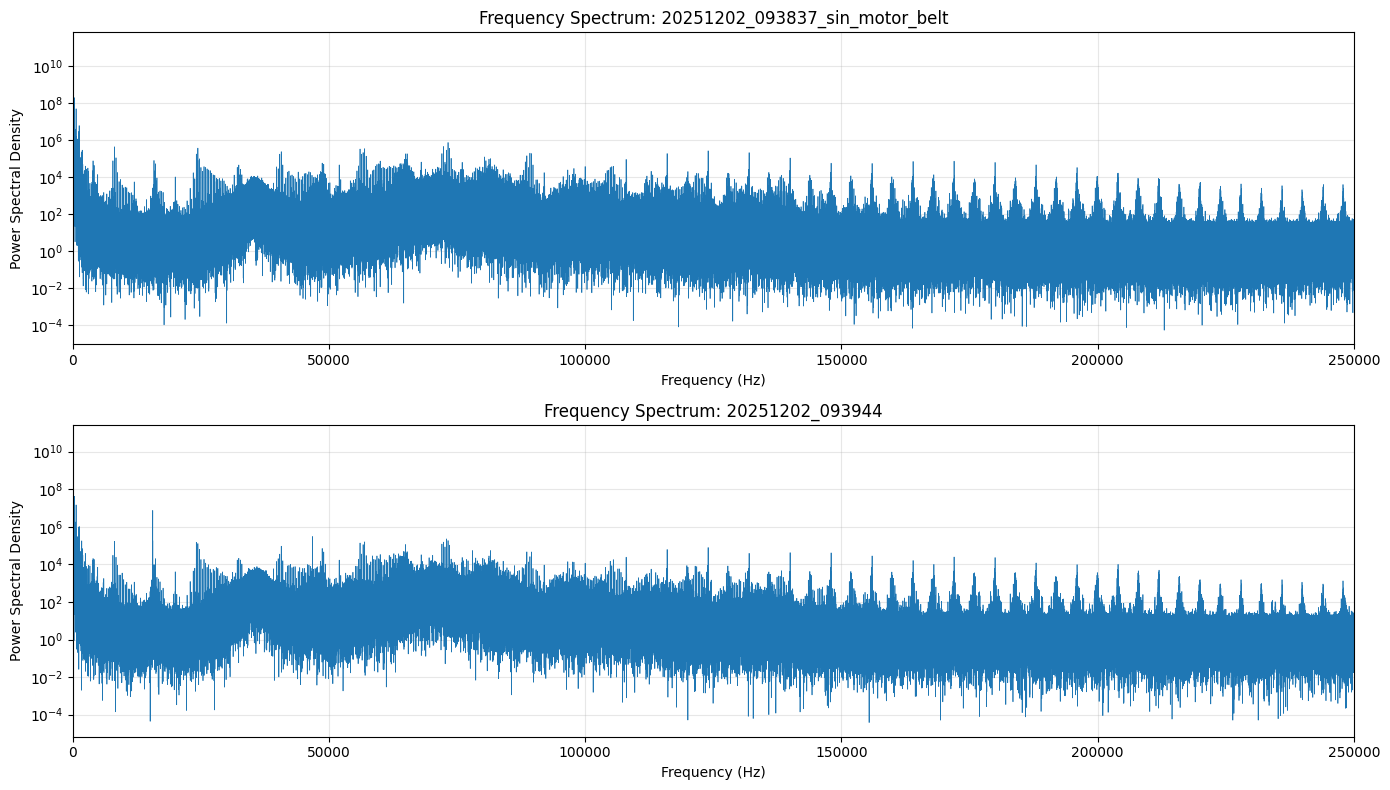

In [36]:
# FFT analysis
fig, axes = plt.subplots(len(noise_data), 1, figsize=(14, 4*len(noise_data)))

if len(noise_data) == 1:
    axes = [axes]

for ax, (label, df) in zip(axes, noise_data.items()):
    voltage = df['Voltage_V'].values
    
    # Calculate sampling frequency from timestamps
    dt = (df['Timestamp_ms'].iloc[1] - df['Timestamp_ms'].iloc[0]) / 1000  # Convert to seconds
    fs = 1 / dt
    
    # Compute FFT
    fft_vals = np.fft.rfft(voltage)
    fft_freq = np.fft.rfftfreq(len(voltage), dt)
    fft_power = np.abs(fft_vals)**2
    
    # Plot power spectrum (log scale)
    ax.semilogy(fft_freq, fft_power, linewidth=0.5)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density')
    ax.set_title(f'Frequency Spectrum: {label}')
    ax.grid(alpha=0.3, which='both')
    ax.set_xlim(0, fs/2)  # Show up to Nyquist frequency

plt.tight_layout()
plt.show()

## Comparison Bar Chart

Compare key noise metrics across all measurements.

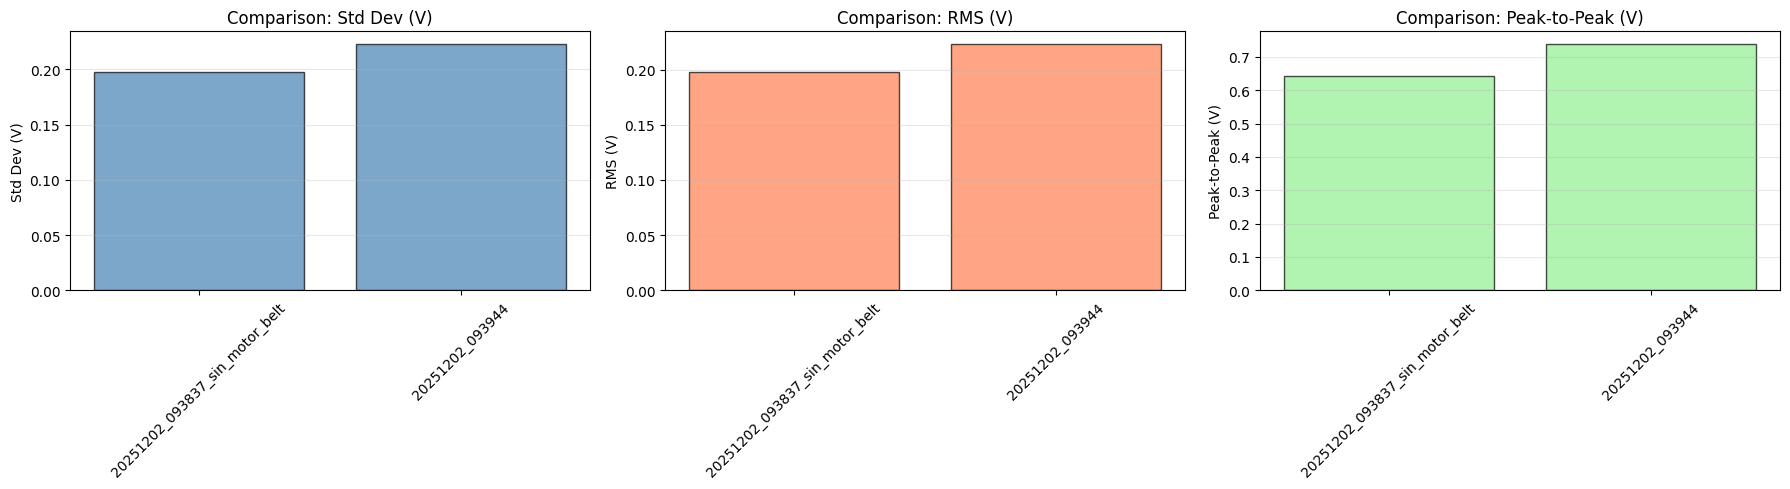

In [37]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Std Dev (V)', 'RMS (V)', 'Peak-to-Peak (V)']
colors = ['steelblue', 'coral', 'lightgreen']

for ax, metric, color in zip(axes, metrics, colors):
    ax.bar(stats_df['Measurement'], stats_df[metric], color=color, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric)
    ax.set_title(f'Comparison: {metric}')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary Report

Final summary of all measurements.

In [38]:
print("="*80)
print("NOISE MEASUREMENT SUMMARY")
print("="*80)
print(f"\nTotal measurements analyzed: {len(noise_data)}\n")

for _, row in stats_df.iterrows():
    print(f"Measurement: {row['Measurement']}")
    print(f"  Mean:         {row['Mean (V)']:.6f} V")
    print(f"  Std Dev:      {row['Std Dev (V)']:.6f} V")
    print(f"  RMS:          {row['RMS (V)']:.6f} V")
    print(f"  Peak-to-Peak: {row['Peak-to-Peak (V)']:.6f} V")
    print(f"  Range:        [{row['Min (V)']:.6f}, {row['Max (V)']:.6f}] V")
    print()

print("="*80)

NOISE MEASUREMENT SUMMARY

Total measurements analyzed: 2

Measurement: 20251202_093837_sin_motor_belt
  Mean:         0.002723 V
  Std Dev:      0.197993 V
  RMS:          0.198012 V
  Peak-to-Peak: 0.643083 V
  Range:        [-0.321667, 0.321416] V

Measurement: 20251202_093944
  Mean:         0.004124 V
  Std Dev:      0.223385 V
  RMS:          0.223423 V
  Peak-to-Peak: 0.739871 V
  Range:        [-0.367270, 0.372602] V

